## Tugas 16 Kelas Data Sains

**Petunjuk** : Baca dan lakukan klustering K-Means pada berkas csv yang disediakan. 
Hal-hal yang harus diperhatikan. 
1. Buka data menjadi data dataframe
2. Buat salinan dataframe dengan dua kolom yaitu attack dan defense
3. Lakukan transformasi pada data
4. Tentukan NIlai K terbaik
5. Lakukan klustering dengan mengacu pada nilai K terbaik
6. Lakukan plot
7. Analisa data tersebut, apa saja yang direpresentasikan oleh tiap
klustering
8. Simpan dalam bentuk ipynb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

### A. Membaca file csv & menyalin fitur yang akan dianalisis

In [ ]:
# 1. Membaca data "data.csv" kemudian mengkonversi menjadi dataframe
df = pd.read_csv("./data.csv")
df.head()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,3,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80
4,4,Charmander,Fire,309,39,52,43,60,50,65


In [ ]:
# 2. Buat salinan dataframe dengan dua kolom yaitu attack dan defense
# Note : Untuk sementara saya menyimpan juga fitur "Name" dan "Type" untuk kepentingan analisis
df2 = df.copy()
features = ["Attack", "Defense"]
df2 = df2[["Name", "Type"]+features]
df2.head()

,Name,Type,Attack,Defense
0,Bulbasaur,Grass Poison,49,49
1,Ivysaur,Grass Poison,62,63
2,Venusaur,Grass Poison,82,83
3,Venusaur Mega Venusaur,Grass Poison,100,123
4,Charmander,Fire,52,43


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     244 non-null    object
 1   Type     244 non-null    object
 2   Attack   244 non-null    int64 
 3   Defense  244 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 7.8+ KB


Pada keterangan dataframe di atas bisa diperoleh beberapa informasi berikut:  
1. Terdapat empat fitur pada dataframe, antara lain : "Name", "Type", "Attack", dan "Defense". Fitur tersebut memiliki makna berturut-turut nama, tipe, kekuatan menyerang dan kemampuan bertahan dari Pokemon.

2. Fitur yang akan digunakan untuk jadi bahan pertimbangan klasterisasi adalah "Attack" dan "Defense". Sedangkan "Name" dan "Type" akan menjadi informasi tambahan pada saat dilakukan analisis nanti.

3. Adapun tipe data dari fitur utama yang akan diolah (Attack dan Defense) tesebut adalah data bertipe integer. 

4. Dari total 244 data, tidak ditemukan nilai fitur yang hilang. Sehingga penanganan data kosong tidak diperlukan pada dataset ini.

### B. Transformasi pada dataframe

**B.1 Persiapan Transformasi Data**

Sebelum melakukan transformasi, baiknya kita lihat terlebih dahulu karakteristik yang meliputi ukuran pemusatan dan penyebaran data. Dari sana, akan ditentukan jenis transformasi mana yang akan dijadikan opsi. 

In [ ]:
df2.describe()

,Attack,Defense
count,244.000000,244.000000
mean,73.639344,69.077869
std,29.072087,27.904564
min,5.000000,5.000000
25%,51.500000,50.000000
50%,71.500000,65.000000
75%,92.000000,85.000000
max,190.000000,180.000000


Pada data statistika di atas diperoleh informasi sebagai berikut
- Dari 244 data "Attack" diperoleh rata-rata sebesar 73.64 dengan standar deviasi 29. Adapun nilai ini terletak pada interval 5 sampai 190. 
- Nilai statistika pada data "Defense" hampir serupa dengan data "Attack". Hal ini bisa dilihat dari nilai mean, range, dan standar deviasi yang tidak jauh berbeda.

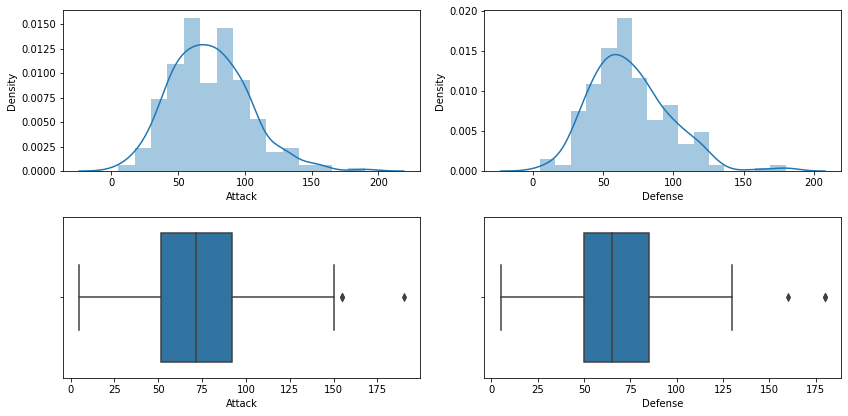

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
sns.distplot(ax=ax[0][0], x=df2.Attack)
ax[0][0].set_xlabel("Attack")

sns.distplot(ax=ax[0][1], x=df2.Defense)
ax[0][1].set_xlabel("Defense")

sns.boxplot(ax=ax[1][0], x=df2.Attack)
ax[1][0].set_xlabel("Attack")

sns.boxplot(ax=ax[1][1], x=df2.Defense)
ax[1][1].set_xlabel("Defense")
fig.tight_layout(pad=1.5)
plt.show()

- Dapat kita lihat pada grafik histogram di atas, baik "Attack" maupun "Defense" mengikuti sebaran distribusi normal karena grafiknya mengikuti kurva normal. 
- Karena sebarannya mengikuti distribusi normal, maka pada saat melakukan transformasi, "Standard Scaler" bisa menjadi salah satu opsi.
- Nampak pula beberapa data pencilan pada masing-masing fitur. Masing-masing data anomali berada pada nilai yang lebih besar dari Q3.
- Karena nilai pencilan pada Attack maupun Defense merupakan nilai yang valid, maka nilai pencilan ini akan dibiarkan.

**B.2  Transformasi Data & Penentuan Nilai Banyak Klaster (K)**

Pada bagian ini akan dilakukan dua jenis transformasi data yakni dengan metode "standar scaler" dan "minmax". Kedua transformasi akan diimplementasikan dengan menggunakan pustaka sklearn. Selanjutnya akan digunakan metode Elbow dan nilai siluet untuk menentukan jumlah kluster yang paling optimal. 

In [ ]:
class KMeansCluster:  
  RANDOM_STATE=1
  def __init__(self, df, columns, n_clusters=2, scaler="standard"):
    # init attribute
    self.__df = df.copy()
    self.__columns = columns
    self.__n_clusters = n_clusters
    self.scaler = KMeansCluster.getScaler(scaler)

    self.__df = self.__df[columns]
    self.__transformData()
    self.__generateCluster()

  @staticmethod
  def getScaler(scaler):
    if (scaler=="standard"):
      return StandardScaler()
    elif (scaler=="minmax"):
      return MinMaxScaler()

  @staticmethod
  def elbowPlot(df, columns, clusterRange, isLog=False):
    if (isLog): KMeansCluster.separation("Elbow Method")
    sse = []
    for k in clusterRange:
      km = KMeans(n_clusters=k, random_state=KMeansCluster.RANDOM_STATE)
      km.fit(df[columns])
      sse.append(km.inertia_)
    
    fig, ax = plt.subplots(figsize=(10,6))        
    ax.set_xlabel('n_cluster')
    ax.set_ylabel('wcss')
    ax.plot(clusterRange,sse)

    plt.title("Elbow Method")
    plt.show()
  
  @staticmethod
  def transformData2(df, columns, scaler, isLog=False):
    scaler=KMeansCluster.getScaler(scaler)
    newColumns = []
    for column in columns:
      scaler.fit(df[[column]])
      df[f"sc_{column}"] = scaler.transform(df[[column]])
      newColumns.append(f"sc_{column}")
    if (isLog) : 
      KMeansCluster.separation(f"Transform Data with {scaler.__str__()}")
      display(df.head())
    return df[newColumns]   
  
  @staticmethod
  def separation(text):
    line = "-"*80
    print("\n"+line)
    print(text)
    print(line)

  def dfLog(self, text):
    KMeansCluster.separation(text)
    display(self.__df.head())

  def __transformData(self):
    for column in self.__columns:
      self.scaler.fit(self.__df[[column]])
      self.__df[f"sc_{column}"] = self.scaler.transform(self.__df[[column]])
  
  def __generateCluster(self):
    self.km = KMeans(n_clusters=self.__n_clusters, random_state=KMeansCluster.RANDOM_STATE)
    self.__df["cluster"] = self.km.fit_predict(self.__df[self.__columns])
    self.dfLog(f"Generating {self.__n_clusters} clusters")
    self.__silhouetteScore = silhouette_score(self.__df[self.__columns], self.__df.cluster)

  def getSilhouetteScore(self):
    return self.__silhouetteScore
  
  def plot(self, isLog=False):
    self.separation("Scatter Plot")
    self.fig, self.ax = plt.subplots(figsize=(10,6))
    sns.scatterplot(
        ax = self.ax,
        data=self.__df, 
        x=f"{self.__columns[0]}", 
        y=f"{self.__columns[1]}", 
        hue="cluster",
        palette="flare"
    )
    sns.scatterplot(
        x=self.km.cluster_centers_[:,0],
        y=self.km.cluster_centers_[:,1],
        color='k',
        s=200
    )
    self.ax.set_xlabel(self.__columns[0])
    self.ax.set_ylabel(self.__columns[1])
    self.fig.show()

  def getDataFrame(self):
    return self.__df



--------------------------------------------------------------------------------
Transform Data with StandardScaler()
--------------------------------------------------------------------------------


,Name,Type,Attack,Defense,sc_Attack,sc_Defense
0,Bulbasaur,Grass Poison,49,49,-0.849268,-0.720998
1,Ivysaur,Grass Poison,62,63,-0.401184,-0.218257
2,Venusaur,Grass Poison,82,83,0.288175,0.499945
3,Venusaur Mega Venusaur,Grass Poison,100,123,0.908598,1.936349
4,Charmander,Fire,52,43,-0.745864,-0.936459



--------------------------------------------------------------------------------
Elbow Method
--------------------------------------------------------------------------------


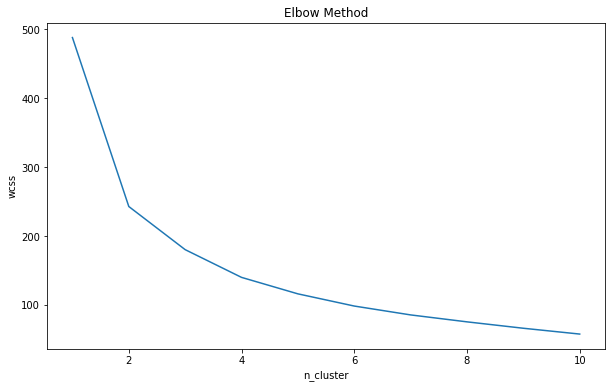

In [ ]:
clusterRange = [i+1 for i in range(10)]

# Transform data using standard scale
stdCluster = KMeansCluster.transformData2(
    df=df2, 
    columns=features, 
    scaler="standard", 
    isLog=True
)
# Generate Elbow plot
KMeansCluster.elbowPlot(
    df = stdCluster, 
    columns = stdCluster.columns,
    clusterRange = clusterRange, 
    isLog=True
)



--------------------------------------------------------------------------------
Transform Data with MinMaxScaler()
--------------------------------------------------------------------------------


,Name,Type,Attack,Defense,sc_Attack,sc_Defense
0,Bulbasaur,Grass Poison,49,49,0.237838,0.251429
1,Ivysaur,Grass Poison,62,63,0.308108,0.331429
2,Venusaur,Grass Poison,82,83,0.416216,0.445714
3,Venusaur Mega Venusaur,Grass Poison,100,123,0.513514,0.674286
4,Charmander,Fire,52,43,0.254054,0.217143



--------------------------------------------------------------------------------
Elbow Method
--------------------------------------------------------------------------------


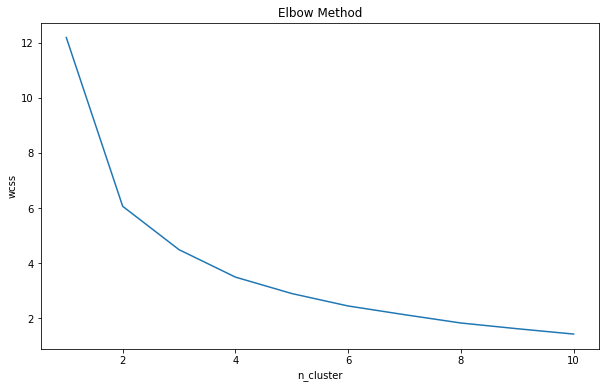

In [ ]:
# Transform data using min max scale
minMaxCluster = KMeansCluster.transformData2(
    df=df2, 
    columns=features, 
    scaler="minmax", 
    isLog=True
)
# Generate Elbow plot
KMeansCluster.elbowPlot(
    df = minMaxCluster, 
    columns = minMaxCluster.columns,
    clusterRange = clusterRange, 
    isLog=True
)

Pada gambar di atas nampak bahwa baik dengan menggunakan transformasi standarisasi maupun min max, keduanya menyarankan untuk membagi data menjadi tiga atau empat klaster. Selanjutnya akan dilihat nilai siluet mana yang lebih besar 

### B. Klasterisasi Dengan nilai K terbaik & Visualisasi Scatter Plot


Metode Transformasi : stardard scale

--------------------------------------------------------------------------------
Generating 3 clusters
--------------------------------------------------------------------------------


,Attack,Defense,sc_Attack,sc_Defense,cluster
0,49,49,-0.849268,-0.720998,1
1,62,63,-0.401184,-0.218257,0
2,82,83,0.288175,0.499945,0
3,100,123,0.908598,1.936349,2
4,52,43,-0.745864,-0.936459,1



Skor Siluet : 0.36227258630563525

--------------------------------------------------------------------------------
Scatter Plot
--------------------------------------------------------------------------------


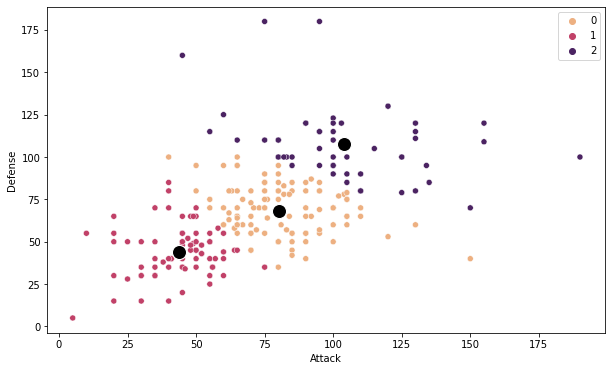

In [ ]:
print(f"\nMetode Transformasi : stardard scale" )
clusterStd3 = KMeansCluster(
    df=df2, 
    columns=features, 
    n_clusters=3, 
    scaler="standard",
)
print(f"\nSkor Siluet : {str(clusterStd3.getSilhouetteScore())}" )
clusterStd3.plot()


Metode Transformasi : stardard scale

--------------------------------------------------------------------------------
Generating 4 clusters
--------------------------------------------------------------------------------


,Attack,Defense,sc_Attack,sc_Defense,cluster
0,49,49,-0.849268,-0.720998,3
1,62,63,-0.401184,-0.218257,0
2,82,83,0.288175,0.499945,0
3,100,123,0.908598,1.936349,1
4,52,43,-0.745864,-0.936459,3



Skor Siluet : 0.3645021680265259

--------------------------------------------------------------------------------
Scatter Plot
--------------------------------------------------------------------------------


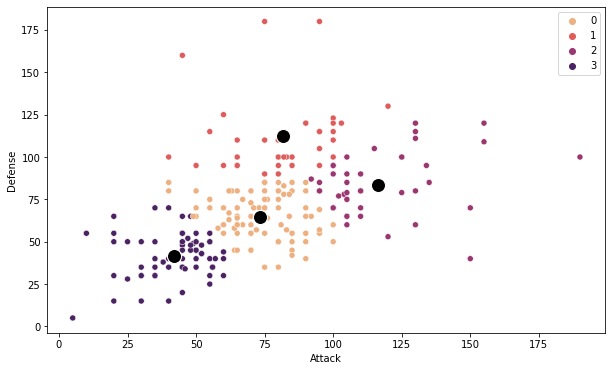

In [ ]:
print(f"\nMetode Transformasi : stardard scale" )
clusterStd4 = KMeansCluster(
    df=df2, 
    columns=features, 
    n_clusters=4, 
    scaler="standard",
)
print(f"\nSkor Siluet : {str(clusterStd4.getSilhouetteScore())}" )
clusterStd4.plot()

Catatan: Hasil ini serupa dengan klasterisasi pada data yang telah ditransformasi dengan metode penskalaan "minmax". Nilai siluet yang lebih besar adalah dengan jumlah klaster 4. 

### C. Analisis tiap klaster

**C.1 Pendahuluan**

Berikut adalah data hasil pengolahan data dengan menggunakan K-Means Clustering. 

In [ ]:
df3 = clusterStd4.getDataFrame() 
df3.head()

,Attack,Defense,sc_Attack,sc_Defense,cluster
0,49,49,-0.849268,-0.720998,3
1,62,63,-0.401184,-0.218257,0
2,82,83,0.288175,0.499945,0
3,100,123,0.908598,1.936349,1
4,52,43,-0.745864,-0.936459,3


In [ ]:
nameType = df2[["Name", "Type"]]
combinedDf = pd.concat([nameType, df3], axis=1)
combinedDf.head()

,Name,Type,Attack,Defense,sc_Attack,sc_Defense,cluster
0,Bulbasaur,Grass Poison,49,49,-0.849268,-0.720998,3
1,Ivysaur,Grass Poison,62,63,-0.401184,-0.218257,0
2,Venusaur,Grass Poison,82,83,0.288175,0.499945,0
3,Venusaur Mega Venusaur,Grass Poison,100,123,0.908598,1.936349,1
4,Charmander,Fire,52,43,-0.745864,-0.936459,3


Dari di atas, kita akan buat dataframe baru untuk melihat resume yang meliputi jenis klaster, banyak pokemon pada masing-masing klaster, kemudian nilai median dari attack dan defense-nya. Nilai median dipilih untuk mewakili masing-masing klaster karena terdapat pencilan data pada beberapa klaster, jika digunakan nilai mean dikhawatirkan tidak mewakili klaster.

In [ ]:
count = []
percent = []
attack = []
defense = []

for i in range(4):
  num = len(df3[df3.cluster==i])
  count.append(num) 
  percent.append(round(num/df3.shape[0]*100,2)) 
  temp = df3[df3.cluster==i]
  attack.append(temp["Attack"].median())
  defense.append(temp["Defense"].median())

resume = pd.DataFrame()
resume["cluster"] = [f"klaster-{i}" for i in range(4)]
resume["count"] = count
resume["percent"] = percent
resume["attack"] = attack
resume["defense"] = defense
resume

,cluster,count,percent,attack,defense
0,klaster-0,96,39.34,75.0,65.0
1,klaster-1,38,15.57,81.0,110.0
2,klaster-2,43,17.62,110.0,80.0
3,klaster-3,67,27.46,45.0,40.0


- Pada tabel di atas diperoleh banyaknya masing-masing kluster, persentasi, nilai median dari attack dan defense.
- Urutan klaster berdasarkan banyaknya pokemon pada dataset adalah klaster-0 (96), klaster-1 (38), klaster-3(67), dan klaster-2(43) 

**C.2 Deskripsi Tiap Klaster**

In [ ]:
def separation(text):
  print("\n"+"-"*80)
  print(text)
  print(""+"-"*80)
    
def showDescription(cluster):
  separation(f"Sample Data Klaster-{cluster}")
  clusterdf = combinedDf[combinedDf.cluster==cluster][["Name", "Type", "Attack", "Defense"]]
  display(clusterdf.head())  
  separation(f"Deskripsi Statistik Klaster-{cluster}")
  display(clusterdf.describe())


**Klaster-0 : Pokemon Sedang**

- Pokemon dengan cluster ini secara umum memiliki kemampuan menyerang dan bertahan yang sedang. 
- Pada pokemon jenis ini, ditemukan juga beberapa pokemon dengan kemampuan menyerang yang tinggi, tapi kemampuan bertahannya berada pada batas bawah kemampuan bertahan klaster ini. 
- Ditemukan pula pokemon dengan bertahan tinggi tapi kemampuan menyerangnya lemah.
- Pokemon dengan cluster ini cukup mendominasi pokedex dengan persentase 39.34%
- Beberapa pokemon pada klaster ini adalah Ivysaur, Venusaur, Charmeleon, dsb


In [ ]:
showDescription(0)


--------------------------------------------------------------------------------
Sample Data Klaster-0
--------------------------------------------------------------------------------


,Name,Type,Attack,Defense
1,Ivysaur,Grass Poison,62,63
2,Venusaur,Grass Poison,82,83
5,Charmeleon,Fire,64,58
6,Charizard,Fire Flying,84,78
10,Wartortle,Water,63,80



--------------------------------------------------------------------------------
Deskripsi Statistik Klaster-0
--------------------------------------------------------------------------------


,Attack,Defense
count,96.00000,96.000000
mean,73.40625,64.572917
std,12.75236,12.595525
min,40.00000,35.000000
25%,65.00000,55.000000
50%,75.00000,65.000000
75%,83.25000,75.000000
max,100.00000,85.000000



**Klaster-3 : Pokemon Lemah**

- Saya kategorikan pokemon pada klaster-3 merupakan pokemon yang lemah, pokemon ini memiliki kemampuan bertahan dan kemampuan menyerang yang lemah.
- Pada klaster ini ditemukan pokemon dengan salah satu kemampuan (menyerang atau bertahan) lebih tinggi dibandingkan pokemon sedang, tapi kemampuan lainnya sangat lemah.
- Jumlah pokemon lemah pada pokedex menempati urutan kedua dengan persentasi 27%.
- Beberapa pokemon pada klaster ini adalah Bulbasaur, Charmander, Squirtle, dsb
- Tidak perlu khawatir jika berhadapan dengan pokemon ini. Karena menghadapi pokemon ini tidak begitu sulit. 



In [ ]:
showDescription(3)


--------------------------------------------------------------------------------
Sample Data Klaster-3
--------------------------------------------------------------------------------


,Name,Type,Attack,Defense
0,Bulbasaur,Grass Poison,49,49
4,Charmander,Fire,52,43
9,Squirtle,Water,48,65
13,Caterpie,Bug,30,35
14,Metapod,Bug,20,55



--------------------------------------------------------------------------------
Deskripsi Statistik Klaster-3
--------------------------------------------------------------------------------


,Attack,Defense
count,67.000000,67.000000
mean,41.880597,41.641791
std,12.391985,13.043867
min,5.000000,5.000000
25%,35.000000,35.000000
50%,45.000000,40.000000
75%,50.000000,50.000000
max,60.000000,70.000000



**Klaster-1 : Pokemon Kuat - Defense Kuat**
- Pokemon ini umumnya memiliki kemampuan bertahan yang sangat baik.
- Ditemukan pula pokemon dengan kemampuan bertahan yang luar biasa, tapi dengan kemampuan menyerang yang sedang atau lemah.
- Jumlah pokemon ini paling sedikit dibandingkan dengan jenis pokemon lain pada dataset ini. Pokemon jenis ini hanya ditemukan 15% dari dataset.
- Venasaur Mega Venusaur, Blastoise, Blastoise Mega Blastoise merupakan beberapa contoh dari pokemon klaster ini.
- Pastikan anda menghadapi ini dengan pokemon yang memiliki kemampuan menyerang yang sangat baik.  

In [ ]:
showDescription(1)


--------------------------------------------------------------------------------
Sample Data Klaster-1
--------------------------------------------------------------------------------


,Name,Type,Attack,Defense
3,Venusaur Mega Venusaur,Grass Poison,100,123
11,Blastoise,Water,83,100
12,Blastoise Mega Blastoise,Water,103,120
37,Sandshrew Alolan Sandshrew,Ice Steel,75,90
38,Sandslash,Ground,100,110



--------------------------------------------------------------------------------
Deskripsi Statistik Klaster-1
--------------------------------------------------------------------------------


,Attack,Defense
count,38.000000,38.000000
mean,81.789474,112.315789
std,18.830909,21.428833
min,40.000000,90.000000
25%,67.500000,100.000000
50%,81.000000,110.000000
75%,95.000000,120.000000
max,120.000000,180.000000



**Klaster-2 : Pokemon Kuat - Attack Kuat**
- Pokemon ini umumnya memiliki kemampuan menyerang yang sangat baik.
- Ditemukan pula pokemon dengan kemampuan menyerang yang luar biasa, tapi kemampuan bertahannya sedang atau lemah.
- Pokemon jenis ini hanya ditemukan 17% dari dataset.
- Charizard Mega Charizard X, Charizard Mega Charizard Y, Beedrill Mega Beedrill merupakan beberapa contoh dari pokemon klaster ini.
- Pastikan menghadapi pokemon ini dengan pokemon dengan bertahan yang baik karena pokemon ini memiliki kemampuan menyerang yang luar biasa. 

In [ ]:
showDescription(2)


--------------------------------------------------------------------------------
Sample Data Klaster-2
--------------------------------------------------------------------------------


,Name,Type,Attack,Defense
7,Charizard Mega Charizard X,Fire Dragon,130,111
8,Charizard Mega Charizard Y,Fire Flying,104,78
19,Beedrill Mega Beedrill,Bug Poison,150,40
42,Nidoqueen,Poison Ground,92,87
45,Nidoking,Poison Ground,102,77



--------------------------------------------------------------------------------
Deskripsi Statistik Klaster-2
--------------------------------------------------------------------------------


,Attack,Defense
count,43.000000,43.000000
mean,116.441860,83.674419
std,20.581201,17.821497
min,92.000000,40.000000
25%,103.000000,70.000000
50%,110.000000,80.000000
75%,130.000000,95.000000
max,190.000000,120.000000


Untuk analisa lebih lanjut, mungkin bisa dielaborasi apakah pokemon tipe tertentu memiliki hubungan erat dengan klaster yang telah dibuat.